# Test to Ensure GPU Functional and Available

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from  IPython import display
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn import datasets
import pandas as pd
import numpy as np
import datetime
import os
from matplotlib import pyplot as plt
import pathlib
import shutil
import tempfile
print(tf.__version__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2.1.0


__DD:__ Check to see if CUDA GPU is available:

In [2]:
tf.test.is_gpu_available(
    cuda_only=True, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

__DD:__ Try new function based on warnings:

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


__DD:__ I was wondering how to make sure GPU does the processing rather than CPU. I found the following excerpt from Tensorflow documentation:  

"If a TensorFlow operation has both CPU and GPU implementations, by default the GPU devices will be given priority when the operation is assigned to a device. For example, tf.matmul has both CPU and GPU kernels. On a system with devices CPU:0 and GPU:0, the GPU:0 device will be selected to run tf.matmul unless you explicitly request running it on another device."  

## Case Study 12

In [5]:
#os.getcwd()
#os.chdir('C:\\Users\\danie\\Documents\\GitHub\\Quantifying-The-World\\Case Study 6\\data')

__DD:__ To get the tensorflow docs packages working I had to clone the github repository to my local file system and run:  
_pip install -q C:\Users\danie\Documents\GitHub\docs_

In [6]:
#get data
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


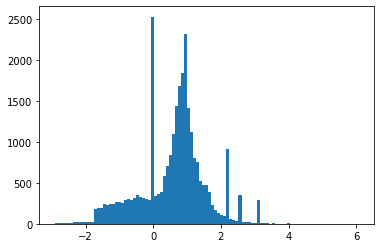

In [7]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

__DD:__ This is where we will tweek to mimic the article

In [8]:
#"parameters were chosen using a subset of the HIGGS data 
#consisting of 2.6 million training examples and 100,000
#validation examples."

N_VALIDATION = int(100)
N_TRAIN = int(300)
BUFFER_SIZE = int(300)
BATCH_SIZE = 300
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [9]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

__DD:__ Original study's code appears to be using a multilayer perceptron ".MLP" as per pylearn documentation.  

According to Tensorflow documentation Sequential() is the equivalent.  

_"To build a simple, fully-connected network (i.e. multi-layer perceptron): model = tf.keras.Sequential()"_

In [15]:
#"We selected a ﬁve-layer neural network with 300 hidden units
#in each layer, a learning rate of 0.05, and a weight decay 
#coeﬃcient of 1×10−5. 

#"Hidden units all used the tanh activation function."

#Weights were initialized from a normal distribution with
#zero mean and standard deviation 0.1 in the ﬁrst layer,
#0.001 in the output layer, and 0.05 all other hidden layers. 

#"Gradient computations were made on mini-batches of size 100.
#A momentum term increased linearly over the ﬁrst 200 epochs 
#from 0.9 to 0.99, at which point it remained constant."

#"The learning rate decayed by a factor of 1.0000002 every
#batch update until it reached a minimum of 10−6"

#"Training ended when the momentum had reached its maximum
#value and the minimum error on the validation set (500,000
#examples) had not decreased by more than a factor of 
#0.00001 over 10 epochs. This early stopping prevented 
#overﬁtting and resulted in each neural network being trained
#for 200-1000 epochs."

# 'Computations were performed using machines with 16 Intel Xeon
# 'cores, an NVIDIA Tesla C2070 graphics processor, and 64 GB 
# 'memory. All neural networks were trained using the GPU-accelerated
# 'Theano and Pylearn2 software libraries [24, 25]. Our code is 
# 'available at https://github.com/uci-igb/higgs-susy.


reproduced_model = tf.keras.Sequential([
    layers.Dense(28, activation='tanh', input_shape=(FEATURES,)),
#    layers.Dense(300, activation='tanh', input_shape=(FEATURES,)),
#    layers.Dense(300, activation='tanh'),
#    layers.Dense(300, activation='tanh'),
    layers.Dense(1)
])
reproduced_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 29        
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________


__DD:__ Code below is for reference. It is from the Github described in the article.  

__Script for training NN on HIGGS dataset.__  
Peter Sadowski  
Simply specify the parameters in the 'main' function. Then run in python.  
This script will generate two files with a common basename generated from the parameters.  

import sys
import os
import theano
import pylearn2
import pylearn2.models.mlp as mlp
import pylearn2.training_algorithms
import pylearn2.training_algorithms.sgd
import pylearn2.costs
import pylearn2.train
import pylearn2.termination_criteria
import pickle as pkl
import numpy as np

#from hyperopt import STATUS_OK, STATUS_FAIL
import pylearn2.datasets.physics
def init_train(args):
    # Interpret arguments.
    derived_feat, seed, nhid, width, lrinit, lrdecay, momentum_init, momentum_saturate, wdecay, dropout_include, = args
    derived_feat = derived_feat # string
    seed = int(seed)
    nhid = int(nhid)
    width = int(width)
    lrinit = float(lrinit)
    lrdecay = float(lrdecay)
    momentum_init = float(momentum_init)
    momentum_saturate = int(momentum_saturate)
    wdecay = float(wdecay)
    dropout_include = float(dropout_include) # dropout include probability in top layer.

    # Specify output files: log and saved model pkl.
    #idpath = os.path.splitext(os.path.abspath(__file__))[0] # ID for output files.

    idpath = ''
    idpath = idpath + '%s_%d_%d_%d_%0.5f_%0.9f_%0.2f_%d_%f_%0.1f' %(derived_feat, seed, nhid, width, lrinit, lrdecay, momentum_init, momentum_saturate, wdecay, dropout_include) 
    save_path = idpath + '.pkl'
    logfile = idpath + '.log'
    print 'Using=%s' % theano.config.device # Can use gpus. 
    print 'Writing to %s' % logfile
    print 'Writing to %s' % save_path
    sys.stdout = open(logfile, 'w')

    # Dataset
    benchmark = 1
    dataset_train = pylearn2.datasets.physics.PHYSICS(which_set='train', benchmark=benchmark, derived_feat=derived_feat)
    #dataset_train = pylearn2.datasets.physics.PHYSICS(which_set='train', benchmark=benchmark, derived_feat=derived_feat, start=0, stop=2600000) # Smaller set for choosing hyperparameters.
    dataset_train_monitor = pylearn2.datasets.physics.PHYSICS(which_set='train', benchmark=benchmark, derived_feat=derived_feat, start=0,stop=100000)
    dataset_valid = pylearn2.datasets.physics.PHYSICS(which_set='valid', benchmark=benchmark, derived_feat=derived_feat)
    dataset_test = pylearn2.datasets.physics.PHYSICS(which_set='test', benchmark=benchmark, derived_feat=derived_feat)

    # Model
    nvis = dataset_train.X.shape[1]
    istdev = 1.0/np.sqrt(width)
    layers = []
    for i in range(nhid):
        # Hidden layer i
        layer = mlp.Tanh(layer_name = 'h%d' % i, dim=width,
                        istdev = (istdev if i>0 else 0.1), # First layer should have higher stdev.
                        )
        layers.append(layer)
    #layers.append(mlp.Sigmoid(layer_name='y', dim=1, istdev=istdev/100.0))
    layers.append(mlp.Sigmoid(layer_name='y', dim=1, istdev=0.001))
    model = pylearn2.models.mlp.MLP(layers, nvis=nvis, seed=seed)

    # Cost
    cost = pylearn2.costs.mlp.Default() # Default cost.
    if dropout_include != 1.0:
        # Use dropout cost if specified.
        cost = pylearn2.costs.mlp.dropout.Dropout(
                        input_include_probs={'y': dropout_include},
                        input_scales={'y': 1.0/dropout_include},
                        default_input_include_prob = 1.0,
                        default_input_scale = 1.0)

    if wdecay != 0.0:
        # Add weight decay term if specified.
        cost2 = pylearn2.costs.mlp.WeightDecay(coeffs = [wdecay]*(nhid+1)) # wdecay if specified.
        cost = pylearn2.costs.cost.SumOfCosts(costs=[cost, cost2])

# Algorithm
    algorithm = pylearn2.training_algorithms.sgd.SGD(
                    batch_size=100,   # If changed, change learning rate!
                    learning_rate = lrinit, #.05, # In dropout paper=10 for gradient averaged over batch. Depends on batchsize.
                    learning_rule = pylearn2.training_algorithms.learning_rule.Momentum(
                                        init_momentum = momentum_init,
                                    ),

                    monitoring_dataset = {'train':dataset_train_monitor,
                                          'valid':dataset_valid,
                                          'test':dataset_test
                                          },

                    termination_criterion=pylearn2.termination_criteria.Or(criteria=[
                                            pylearn2.termination_criteria.MonitorBased(
                                                channel_name="valid_y_kl",
                                                prop_decrease=0.00001,
                                                N=10),

                                            pylearn2.termination_criteria.EpochCounter(
                                                max_epochs=momentum_saturate)
                                            ]),
                    cost=cost,
                    update_callbacks=pylearn2.training_algorithms.sgd.ExponentialDecay(
                                        decay_factor = lrdecay, #1.0000002 # Decreases by this factor every batch. (1/(1.000001^8000)^100 
                                        min_lr=.000001
                                        )
                )

    # Extensions 

    extensions=[ 
        #pylearn2.train_extensions.best_params.MonitorBasedSaveBest(channel_name='train_y_misclass',save_path=save_path)
        pylearn2.training_algorithms.learning_rule.MomentumAdjustor(
            start=0,
            saturate = momentum_saturate, # 200,500
            final_momentum = 0.99,  # Dropout=.5->.99 over 500 epochs.
            )
        ]
    # Train
    train = pylearn2.train.Train(dataset=dataset_train,
                                 model=model,
                                 algorithm=algorithm,
                                 extensions=extensions,
                                 save_path=save_path,
                                 save_freq=100)

    return train

 
def compute_objective(args):
    '''Initializes neural network with specified arguments and trains.'''    
    # Train network.
    train = init_train(args)
    train.main_loop()
    model = train.model
     
    # Return objective to hyperopt.
    loss = train.model.monitor.channels['valid_y_kl'].val_record[-1]
    return loss
    #return {"loss":loss,"status":STATUS_OK}

if __name__=='__main__':
    # Initialize and train.
    #args = (derived_feat, seed, nhid, width, lrinit, lrdecay, momentum_init, momentum_saturate, wdecay, dropout_include)
    args = ('True', 42, 1, 1000, 0.0005, 1.0000005, 0.9, 200, 0.00000, 1.0)
    compute_objective(args)

In [17]:
reproduced_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True,name='binary_crossentropy')])

In [18]:
reproduced_model.fit(train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=1000,
    validation_data=validate_ds,
    verbose=0
)

In [13]:
reproduced_model.evaluate(validate_ds)

      1/Unknown - 0s 25ms/step - loss: 1.1620 - binary_crossentropy: 1.1620

[1.1619526147842407, 1.1619526]